In [126]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
seed(1)

In [127]:
#operator definitionis
N = 2
si = qeye(2)
sx = 0.5*sigmax()
sy = 0.5*sigmay()
sz = 0.5*sigmaz()

In [128]:
#make list of tensor products
sx_list = []
sy_list = []
sz_list = []

for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(si)

    op_list[n] = sx
    sx_list.append(tensor(op_list))

    op_list[n] = sy
    sy_list.append(tensor(op_list))

    op_list[n] = sz
    sz_list.append(tensor(op_list))


In [129]:
#Construct Hamiltonian
B = 0
A0 = 1
H = B*sz_list[0] 
for n in range(N-1):
    H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
print(H)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.25  0.    0.    0.  ]
 [ 0.   -0.25  0.5   0.  ]
 [ 0.    0.5  -0.25  0.  ]
 [ 0.    0.    0.    0.25]]


In [130]:
#Find Groundstate
H.groundstate()

(-0.7500000000000001,
 Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[ 0.        ]
  [ 0.70710678]
  [-0.70710678]
  [ 0.        ]])

In [131]:
#Make basis
Sbasis = []
for i in range(N):
    for j in range(N):
        Sbasis.append(tensor([basis(N,i),basis(N,j)]))
print(Sbasis)


[Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]], Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]], Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]], Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]]]


In [132]:
#get sz values for basis states
sz = np.zeros((2**N,N), dtype = complex)
a = [[1 for j in range(N)] for i in range(2**N)]
for i in range(2**N):
    for j in range(N):
        #matrix element <bra|Sz|ket>
        sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])

print(sz)

[[ 0.5+0.j  0.5+0.j]
 [ 0.5+0.j -0.5+0.j]
 [-0.5+0.j  0.5+0.j]
 [-0.5+0.j -0.5+0.j]]


In [223]:
#Define RBM Parameters
M = 2
alp = M/N

a = rand(N)
b = rand(M)
W = rand(M,N)

In [224]:
#Function to give RBM wavefuntion
def RBM_ansatz(a, b, W, Sbasis, N, M,sz):
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = np.cosh(np.dot(W[m],sz[i]) + b[m])

    hidProduct = 2*np.prod(coshTerm, axis = 0)   
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
        
    return psiM


In [225]:
#Variation Energy Definition
def varEnergy(a, b, W, Sbasis, N, M,sz, H):
    psiM = RBM_ansatz(a, b, W, Sbasis, N, M, sz)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

E = varEnergy(a, b, W, Sbasis, N, M,sz, H)
print(E)

0.2476394368894138


In [226]:
#Gradient Descent 
def updateParameters(a, b, W, Sbasis, N, M,sz, H, learning_rate):
    #Find partials
    eps = 0.5
    a_partials = optimize.approx_fprime(a,varEnergy,eps,b,W,Sbasis, N, M,sz, H)
    b_partials = optimize.approx_fprime(b,varEnergy,eps,a,W,Sbasis, N, M,sz, H)
    a_diff = (-1)*a_partials*learning_rate
    b_diff = (-1)*b_partials*learning_rate
    
    for i in range(N):
        a[i] += a_diff[i]
    for m in range(M):
        b[m] += b_diff[i]
        
    diff = np.amax(np.maximum(a_diff,b_diff))
    return a, b, diff

print(a)

c = updateParameters(a, b, W, Sbasis, N, M,sz, H, 0.3)[2]

print(c)





[0.4173048  0.55868983]
0.009467683193699733


In [227]:
#Minimize Energy
E = []
iteration = []
diff = 1
itValue = 0

while diff > 0.0001:
    E.append(varEnergy(a, b, W, Sbasis, N, M,sz, H))
    newParams = updateParameters(a, b, W, Sbasis, N, M,sz, H, 0.3)
    diff = newParams[2]
    #count interations
    itValue = itValue + 1
    iteration.append(itValue)
    
print(E)


[0.2474241016796849, 0.2471999733318761, 0.2469670615895347, 0.24672535533321518, 0.24647482169788143, 0.24621540526829225, 0.24594702732304957, 0.24566958510099354, 0.24538295106620417, 0.24508697215003553, 0.24478146895036546, 0.24446623486962366, 0.2441410351741677, 0.243805605958242, 0.24345965299608283, 0.24310285046574168, 0.24273483952789454, 0.24235522674229582, 0.2419635823036072, 0.24155943807709704, 0.24114228541313387, 0.24071157271748006, 0.2402667027521023, 0.23980702963851627, 0.23933185553253977, 0.23884042693568497, 0.23833193060422334, 0.23780548901212434, 0.2372601553185274, 0.23669490778404906, 0.23610864357293107, 0.2355001718696795, 0.2348682062292428, 0.234211356068765, 0.23352811719629404, 0.23281686125726228, 0.23207582396281337, 0.23130309194474358, 0.23049658805958492, 0.22965405493869379, 0.22877303655158734, 0.22785085751557685, 0.22688459984525053, 0.22587107678977106, 0.22480680335333475, 0.22368796303349306, 0.22251037024222525, 0.22126942779448938, 0.21

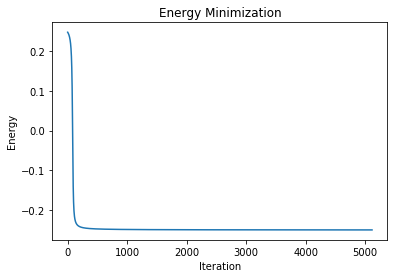

In [228]:
plt.title("Energy Minimization")
plt.plot(iteration,E)
plt.ylabel('Energy')
plt.xlabel('Iteration')
plt.show()